### Import data

In [1]:
import re
import json
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Read raw data

In [2]:
chatgpt_data = pd.read_excel("../data/labeled/intent/chatgpt_intents.xlsx").fillna(0)
human_data = pd.read_excel("../data/labeled/intent/human_intents.xlsx").fillna(0)

In [3]:
chatgpt_data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info
0,"thôi shop oi, hủy đon hàng của tao đi",0,0,0,0,0,0,0,1,0
1,"Hủy đơn hàng đi, tớ đổi ý rồi!",0,0,0,0,0,0,0,1,0
2,confirm lại giup em đơn hàng mới voi ạ,0,0,0,0,0,1,0,0,0
3,có cách nào biết được đơn hàng của mình đang ở...,0,0,0,0,0,0,1,0,0
4,"thay đổi địa chỉ giao hàng: 456 Đường XYZ, Quậ...",0,0,0,0,0,0,0,0,1


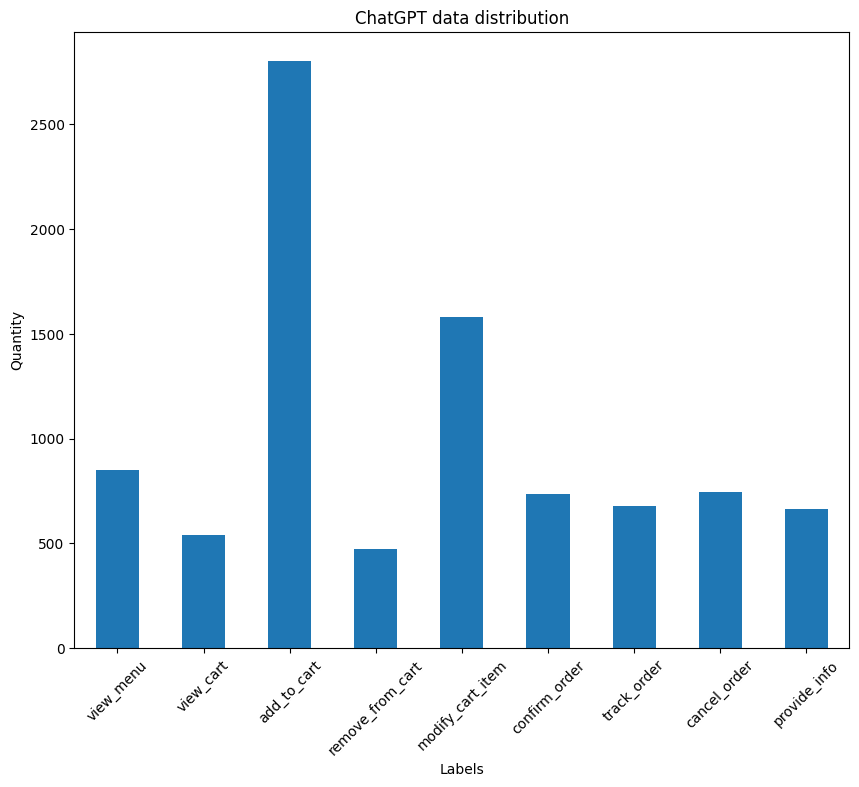

In [4]:
chatgpt_label_counts = chatgpt_data.drop(columns=['text']).sum()

plt.figure(figsize=(10, 8))
chatgpt_label_counts.plot(kind='bar')
plt.title('ChatGPT data distribution')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

In [5]:
human_data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info
0,cái pizza new oceania đó hết bao nhiêu tiền vậ...,1,0,0,0,0,0,0,0,0
1,cái pizza margherita có mắc không,1,0,0,0,0,0,0,0,0
2,cho mình hỏi pizza có thêm topping ko,1,0,0,0,0,0,0,0,0
3,bạn ơi cái pizza pepperoni giá sao vậy,1,0,0,0,0,0,0,0,0
4,bán cái pizza này bao nhiu tiền zậy,1,0,0,0,0,0,0,0,0


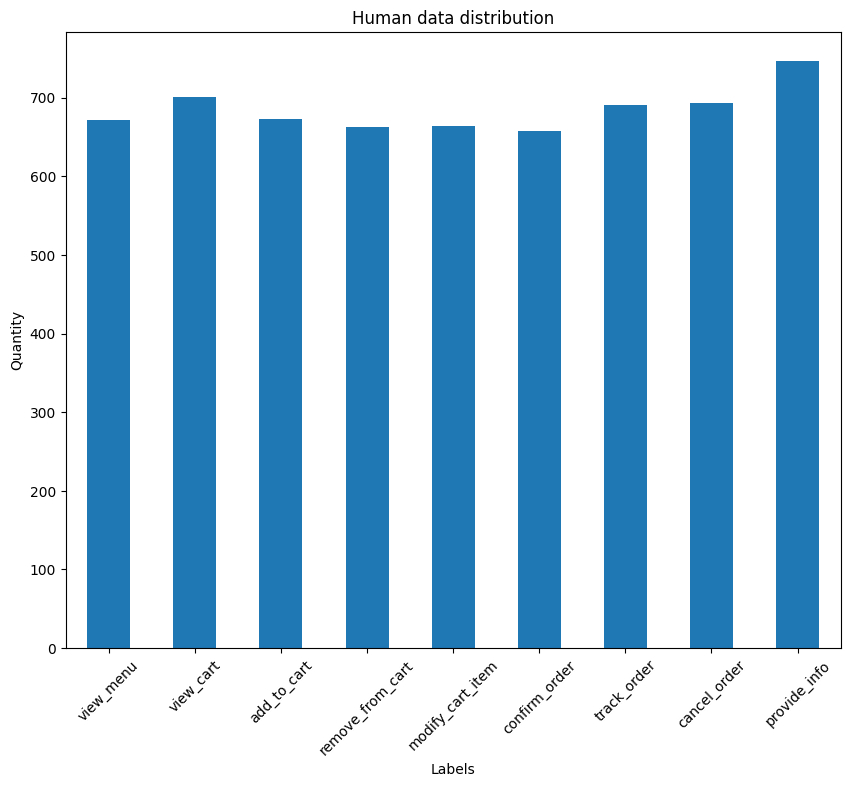

In [6]:
human_label_counts = human_data.drop(columns=['text']).sum()

plt.figure(figsize=(10, 8))
human_label_counts.plot(kind='bar')
plt.title('Human data distribution')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

### Apply preprocessing function

In [7]:
def read_acronym_dictionary(dictionary_path="utils/acronym_dictionary.json"):
    with open(dictionary_path, 'r', encoding="utf-8") as file:
        acronym_dictionary = json.load(file)
    return acronym_dictionary

def lowercase_text(text: str): 
    return text.lower()

def remove_diacritic(text: str):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).replace("đ", "d")

def translate(text: str, acronym_dictionary: dict):
    sorted_items = sorted(acronym_dictionary.items(), key=lambda x: len(x[0]), reverse=True)
    for original, token in sorted_items:
        pattern = re.compile(r'\b' + re.escape(original) + r'\b', re.IGNORECASE)
        text = pattern.sub(token, text)
    return text

def translate_text(text: str, acronym_dictionary: dict):
    tokenized_text = translate(text, acronym_dictionary)

    list_token_tokenized_text = tokenized_text.split()
    token_diacritic_map = {}
    no_diacritic_text = ""
    for index, token in enumerate(list_token_tokenized_text):
        if "_" not in token:
            token_diacritic_map[remove_diacritic(token)] = index
            no_diacritic_text += remove_diacritic(token) + " "
    no_diacritic_text = no_diacritic_text.strip()

    no_diacritic_tokenized_text = translate(no_diacritic_text, acronym_dictionary)
    for no_diacritic_token in no_diacritic_tokenized_text.split():
        if "_" in no_diacritic_token:
            start_of_word = float('inf')
            end_of_word = float('-inf')
            for part_token in no_diacritic_token.split("_"):
                part_token = remove_diacritic(part_token)
                start_of_word = min(start_of_word, token_diacritic_map.get(part_token))
                end_of_word = max(end_of_word, token_diacritic_map.get(part_token)) + 1
            list_token_tokenized_text[start_of_word : end_of_word] = [no_diacritic_token]
    
    return " ".join([token for token in list_token_tokenized_text])

def preprocessing(text: str, acronym_dictionary: dict = read_acronym_dictionary()):
    text = lowercase_text(text)
    text = translate_text(text, acronym_dictionary)
    return text

In [8]:
chatgpt_data["text_clean"] = chatgpt_data["text"].apply(preprocessing)
human_data["text_clean"] = human_data["text"].apply(preprocessing)

In [9]:
chatgpt_data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
0,"thôi shop oi, hủy đon hàng của tao đi",0,0,0,0,0,0,0,1,0,"thôi shop oi, hủy đon hàng của tao đi"
1,"Hủy đơn hàng đi, tớ đổi ý rồi!",0,0,0,0,0,0,0,1,0,"hủy đơn hàng đi, tớ đổi ý rồi!"
2,confirm lại giup em đơn hàng mới voi ạ,0,0,0,0,0,1,0,0,0,confirm lại giup em đơn hàng mới voi ạ
3,có cách nào biết được đơn hàng của mình đang ở...,0,0,0,0,0,0,1,0,0,có cách nào biết được đơn hàng của mình đang ở...
4,"thay đổi địa chỉ giao hàng: 456 Đường XYZ, Quậ...",0,0,0,0,0,0,0,0,1,"thay đổi địa chỉ giao hàng: 456 đường xyz, quậ..."


In [10]:
human_data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
0,cái pizza new oceania đó hết bao nhiêu tiền vậ...,1,0,0,0,0,0,0,0,0,cái pizza new oceania đó hết bao nhiêu tiền vậ...
1,cái pizza margherita có mắc không,1,0,0,0,0,0,0,0,0,cái pizza margherita có mắc không
2,cho mình hỏi pizza có thêm topping ko,1,0,0,0,0,0,0,0,0,cho mình hỏi pizza có thêm topping không
3,bạn ơi cái pizza pepperoni giá sao vậy,1,0,0,0,0,0,0,0,0,bạn ơi cái pizza pepperoni giá sao vậy
4,bán cái pizza này bao nhiu tiền zậy,1,0,0,0,0,0,0,0,0,bán cái pizza này bao nhiêu tiền vậy


### Balancing ChatGPT data distribution

In [11]:
chatgpt_add_to_cart_samples = chatgpt_data[chatgpt_data['add_to_cart'] == 1].sample(n=750, random_state=42)
chatgpt_remaining_samples = chatgpt_data[chatgpt_data['add_to_cart'] == 0]

chatgpt_modify_cart_samples = chatgpt_remaining_samples[chatgpt_remaining_samples['modify_cart_item'] == 1].sample(n=754, random_state=42)
final_chatgpt_remaining_samples = chatgpt_remaining_samples[chatgpt_remaining_samples['modify_cart_item'] == 0]

final_chatgpt_data = pd.concat([chatgpt_add_to_cart_samples, chatgpt_modify_cart_samples, final_chatgpt_remaining_samples])

In [12]:
final_chatgpt_data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,text_clean
3788,"hai pizza double cheese burger cỡ nhỏ, không t...",0,0,1,0,0,0,0,0,0,"hai pizza double cheese burger cỡ nhỏ, không t..."
2565,"thèm thêm một chiếc pizza BBQ chicken nữa, nhớ đó",0,0,1,0,0,0,0,0,0,"thèm thêm một chiếc pizza bbq chicken nữa, nhớ đó"
6807,"Làm thêm một pizza Margherita, size vừa, crust...",0,0,1,0,0,0,0,0,0,"làm thêm một pizza margherita, size vừa, crust..."
4145,"gọi pizza Meat Lovers, cỡ nhỏ, thêm nấm rơm và...",0,0,1,0,0,0,0,0,0,"gọi pizza meat lovers, cỡ nhỏ, thêm nấm rơm và..."
6223,"đặt một pizza giống như lần trước, cảm ơn nhé",0,0,1,0,0,0,0,0,0,"đặt một pizza giống như lần trước, cảm ơn nhé"


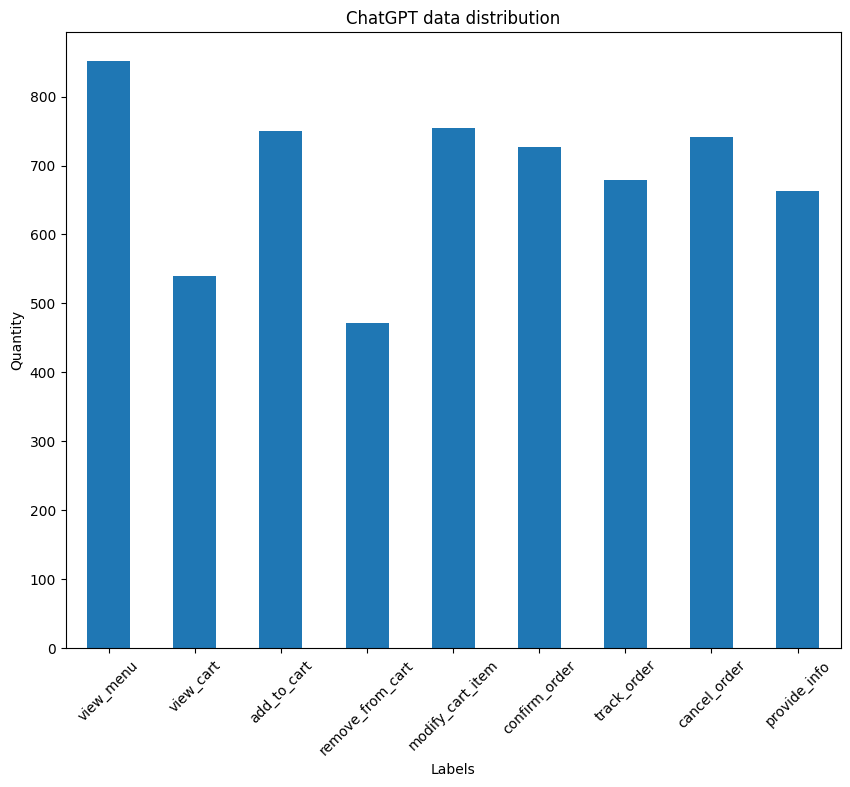

In [13]:
final_chatgpt_label_counts = final_chatgpt_data.drop(columns=['text', 'text_clean']).sum()

plt.figure(figsize=(10, 8))
final_chatgpt_label_counts.plot(kind='bar')
plt.title('ChatGPT data distribution')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

In [14]:
print("ChatGPT data shape:", final_chatgpt_data.shape)
print("Human data shape:", human_data.shape)

ChatGPT data shape: (6160, 11)
Human data shape: (6160, 11)


### Split data for training

In [15]:
def split_data(df, test_size):
    test_data = df.sample(n=test_size, random_state=42)
    remaining_data = df.drop(test_data.index)
    return remaining_data, test_data

chatgpt_train_data, chatgpt_test_data = split_data(final_chatgpt_data, 1160)
human_train_data, human_test_data = split_data(human_data, 1160)

In [16]:
def combine_data(df1, df2, size):
    df1_sample = df1.sample(n=size, random_state=42)
    df2_sample = df2.sample(n=size, random_state=42)
    combined_df = pd.concat([df1_sample, df2_sample], ignore_index=True)
    return combined_df

chatgpt_50_human_50_data = combine_data(chatgpt_train_data, human_data, 2500)

### Export data

In [43]:
chatgpt_train_data.drop(columns=['text']).to_excel("intents_100_chatgpt.xlsx", index=False)
human_train_data.drop(columns=['text']).to_excel("intents_100_human.xlsx", index=False)
chatgpt_50_human_50_data.drop(columns=['text']).to_excel("intents_50_chatgpt_50_human.xlsx", index=False)
chatgpt_test_data.drop(columns=['text']).to_excel("intents_test_gpt.xlsx", index=False)
human_test_data.drop(columns=['text']).to_excel("intents_test_human.xlsx", index=False)